In [18]:
%matplotlib notebook
from ipywidgets import *
from IPython.display import display, Math

import os; import importlib
import sys; sys.path.append('C:/Users/' + os.getlogin() + '/Dropbox/Python')
from myutils import *

def get_H_0(Nx, Ny, t, a_SO, mu, PBC_x,
            impurity_loc, impurity_amp, impurity_magnetic):
    hop_x = sparse.kron(sparse.eye(Nx, k=1) + PBC_x*sparse.eye(Nx, k=-Nx+1),
                        sparse.kron(sparse.eye(Ny), -t*sparse.eye(2)) +\
                        sparse.kron(Paulis[0], 1j*a_SO*Paulis[2]) )
    hop_y = sparse.kron(sparse.eye(Nx), sparse.kron(
        sparse.eye(Ny, k=1), -t*sparse.eye(2) - 1j*a_SO*Paulis[1]))
    H_hop = hop_x + hop_y
    H_imp = 0*sparse.eye(Nx*Ny*2)
    for j in range(len(impurity_loc)):
        H_imp += impurity_amp*sparse.kron(sparse.diags(
            (np.arange(Nx) == impurity_loc[j][0]).astype(float)),
            sparse.kron(sparse.diags(
                (np.arange(Ny) == impurity_loc[j][1]).astype(float)),
                Paulis[1 if impurity_magnetic else 0]))
    H_0 = H_hop + hc(H_hop) - (mu - 4*t)*sparse.eye(Nx*Ny*2) + H_imp
    return H_0

def get_H_BdG_three_phases(L_left, L_right, L_1, L_2, L_3, Ny, t, a_SO, mu,
                           Delta, phi_left, phi_right, phi_1, phi_2, phi_3,
                           PBC_x, impurity_amp, impurity_magnetic):
    x_left = L_left - 1
    x_right = L_left + L_1 + L_2 + L_3
    impurity_loc = [[x_left, 0], [x_left,1], [x_right, 0], [x_right, 1]]
    Nx = L_left + L_right + L_1 + L_2 + L_3
    H_0 = get_H_0(Nx, Ny, t, a_SO, mu, PBC_x,
                  impurity_loc, impurity_amp, impurity_magnetic)
    SC_phase = np.concatenate(( np.tile(phi_left, L_left), np.tile(phi_1, L_1),
                           np.tile(phi_2, L_2), np.tile(phi_3, L_3),
                           np.tile(phi_right, L_right) ))
    H_SC = Delta*sparse.kron(sparse.diags(np.exp(1j*SC_phase)),
                         sparse.kron(sparse.eye(Ny), 1j*Paulis[2]))
    return sparse.bmat([[H_0, H_SC], [hc(H_SC), -H_0.T]])

<IPython.core.display.Javascript object>


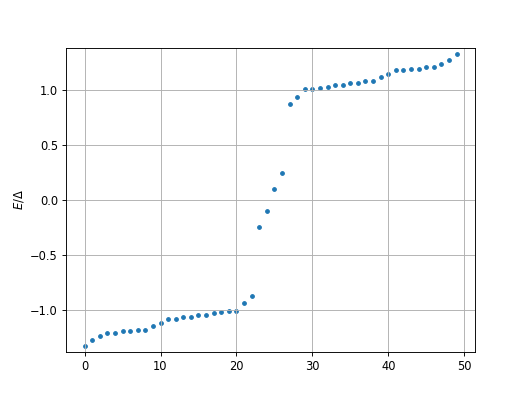

interactive(children=(IntSlider(value=20, description='L_out', max=40, min=5), IntSlider(value=10, description…

In [20]:
t = 1
a_SO = 0.5
mu = 1.5
PBC_x = 0#1
Delta = 0.6

Ny = 2
L_left = 30
L_right = L_left
L_1 = 2
L_2 = L_1; L_3 = L_1

phi_left = 0
phi_right = 0
phi_1 = 2*np.pi/3
phi_2 = 4*np.pi/3
phi_3 = 6*np.pi/3
# phi_1 = 1; phi_2 = 2; phi_3 = 3

impurity_amp = 0
impurity_magnetic = 0

f = np.cos(phi_1-phi_2) + np.cos(phi_2-phi_3) + np.cos(phi_3-phi_1)
Nx = L_left + L_right + L_1 + L_2 + L_3

def get_energies(L_out, L_seg, impurity_amp=impurity_amp, phi_1=phi_1, phi_2=phi_2, phi_3=phi_3, mu=mu, a_SO=a_SO):
    L_left = L_out; L_right = L_out
    L_1 = L_seg; L_2 = L_seg; L_3 = L_seg
    phi_left = phi_3
    H_BdG = get_H_BdG_three_phases(
        L_left, L_right, L_1, L_2, L_3, Ny, t, a_SO, mu,
        Delta, phi_left, phi_right, phi_1, phi_2, phi_3,
        PBC_x, impurity_amp, impurity_magnetic)
    E = sploweigs(H_BdG, num_eigs=50)
    return E

E = get_energies(L_left, L_1)
fig = plt.figure(dpi=75)
scat = plt.scatter(range(len(E)), E/Delta, s=10)
plt.ylabel(r'$E/\Delta$')
plt.grid()

def update(L_out=20, L_seg=10, impurity_amp=impurity_amp, phi_1=phi_1, phi_2=phi_2, phi_3=phi_3, mu=mu, a_SO=a_SO):
    E = get_energies(L_out, L_seg, impurity_amp=impurity_amp, phi_1=phi_1, phi_2=phi_2, phi_3=phi_3, mu=mu, a_SO=a_SO)
    #line.set_ydata(E_vec/Delta)
    scat.set_offsets(np.column_stack((range(len(E)),E/Delta)))
    fig.canvas.draw_idle()

interact(update, L_out=(5, 40), L_seg=(1, 20), impurity_amp=(-20, 20, 0.1),
         phi_1=(0, 2*np.pi, 0.1), phi_2=(0, 2*np.pi, 0.1), phi_3=(0, 2*np.pi, 0.1),
         mu=(0, 2, 0.1), a_SO=(0, 5, 0.1));